### Basic Generative Adversarial Network - Trained on MNIST DATASET

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

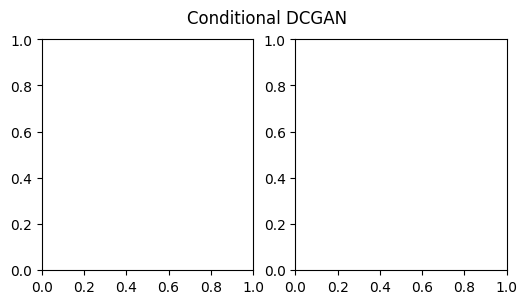

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle("Conditional DCGAN")
def save_images(real_image: torch.tensor, gen_image: torch.tensor, num_images = 25, size=(1, 28, 28), idx: int = -1):
    for i in range(2):
        ax[i].axis("off")
        images = real_image if i == 0 else gen_image
        ax[i].set_title("True Images" if i==0 else "Generated Images", fontsize=10)
        image_unflat = images.detach().cpu().view(-1, *size)
        image_grid = make_grid(image_unflat[:num_images], nrow=5)
        ax[i].imshow(image_grid.permute(1, 2, 0).squeeze())
        fig.savefig(f"./outputs/output_{idx}.png", dpi=200)

In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )
        
    def forward(self, noise):
        
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

In [4]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=64):
        super().__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
def get_one_hot_labels(labels, n_classes, device="cuda"):
    return F.one_hot(labels, n_classes).to(device)

def combine_vectors(x, y, device="cuda"):
    return torch.cat((x.float(), y.float()), dim=1).to(device)

In [7]:
mnist_shape = (1, 28, 28)
n_classes = 10
criterion = nn.BCEWithLogitsLoss()
n_epochs = 300
z_dim = 64
show_epoch = 1
checkpoint_epoch = 25
batch_size = 128
lr = 0.0002
device = "cuda"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True
    )

In [8]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_input_channels = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_input_channels

In [9]:
gen_in_dim, disc_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

# INITIALIZING NETWORKS
gen = Generator(gen_in_dim).to(device)
disc = Discriminator(disc_im_chan).to(device)

# OPTIMIZERS
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)



def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# LOADING
# Uncomment to Load Trained Generator
gen.load_state_dict(torch.load("./gen_state_300"))
disc.load_state_dict(torch.load("./disc_state_300"))

<All keys matched successfully>

In [ ]:
for epoch in range(1, n_epochs+1):
    for real, labels in tqdm(dataloader):
        real = real.to(device)
        current_batch_size = len(real)

        # Getting one hot information for generator and discriminator
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])
        
        # Updating Discriminator
        disc_opt.zero_grad(set_to_none=True)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_real_pred = disc(real_image_and_labels)
        
        noise = get_noise(current_batch_size, z_dim, device=device)
        noise_and_labels = combine_vectors(noise, one_hot_labels)
        generated_images = gen(noise_and_labels).detach()
        generated_images_and_labels = combine_vectors(generated_images, image_one_hot_labels)
        disc_fake_pred = disc(generated_images_and_labels)

        # Calculating Discriminator's Loss
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Updating Generator
        gen_opt.zero_grad(set_to_none=True)
        noise = get_noise(current_batch_size, z_dim, device=device)
        noise_and_labels = combine_vectors(noise, one_hot_labels)
        generated_images = gen(noise_and_labels)
        fake_images_and_labels = combine_vectors(generated_images, image_one_hot_labels)
        disc_pred = disc(fake_images_and_labels)

        # Calculating Generator's Loss
        gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
        gen_loss.backward()
        gen_opt.step()

    if epoch % show_epoch == 0:
        print(f"Epoch {epoch}: Generator Loss: {gen_loss:2f} | Discriminator Loss: {disc_loss:2f}")
        save_images(real, generated_images, idx=epoch)
    if epoch % checkpoint_epoch == 0:
        torch.save(disc.state_dict(), f"./disc_state_{epoch}")
        torch.save(gen.state_dict(), f"./gen_state_{epoch}")